source: https://torchhd.readthedocs.io/en/stable/getting_started.html



# Basis-hypervectors

Types:
- **empty**(num_vectors, dimensions[, vsa]): Creates a set of hypervectors representing empty sets.
- **identity**(num_vectors, dimensions[, vsa]): Creates a set of identity hypervectors.
- **random**(num_vectors, dimensions[, vsa]): Creates a set of random independent hypervectors.
- **level**(num_vectors, dimensions[, vsa, ...]): Creates a set of level correlated hypervectors.
- **thermometer**(num_vectors, dimensions[, vsa, ...]): Creates a thermometer code for given dimensionality.
- **circular**(num_vectors, dimensions[, vsa, ...]): Creates a set of circularly correlated hypervectors.

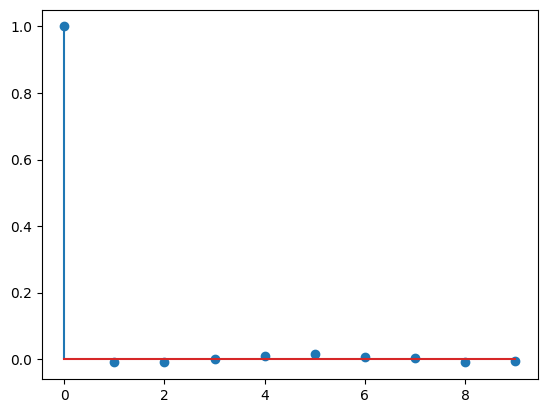

/Users/arvandkaveh/Projects/kit/graph_hdc/.pixi/envs/default/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


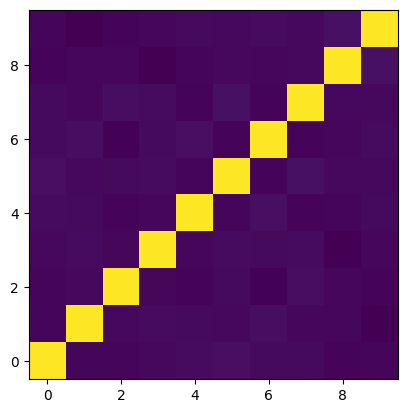

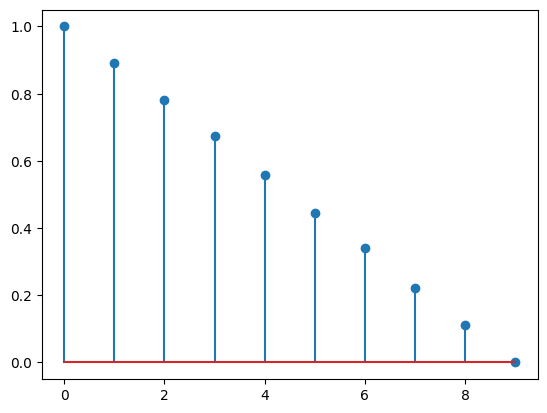

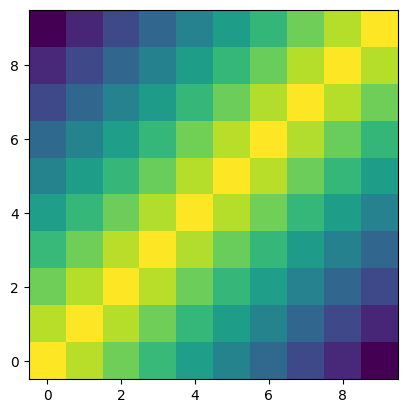

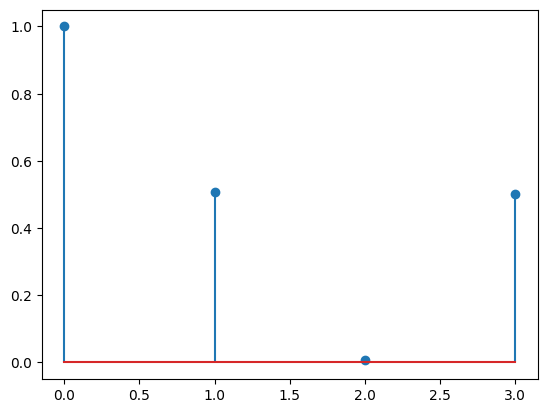

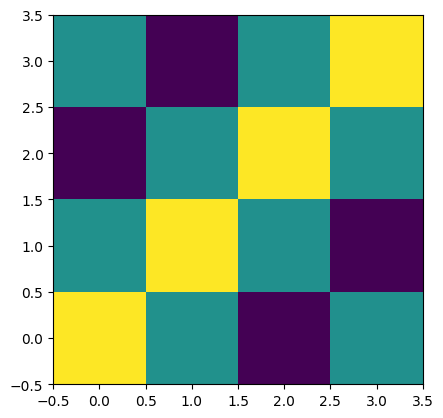

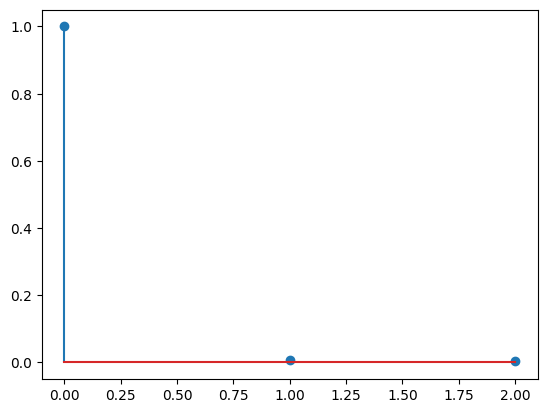

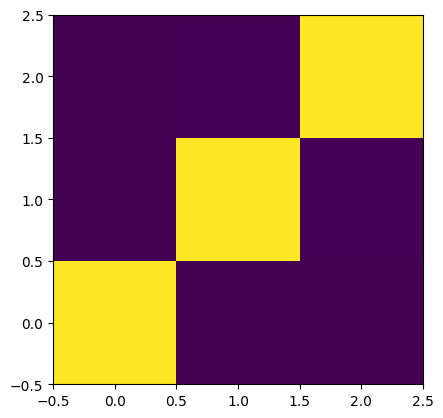

In [1]:
import matplotlib.pyplot as plt
import torchhd
from torchhd import utils

d = 10000  # dimensions
fruits = torchhd.random(10, d)
weights = torchhd.level(10, d)  ## quasi orthogonal hyper vectors, 10 weight levels
seasons = torchhd.circular(4, d)  ## Any hypervector is quasi-orthogonal to the hypervector opposite site of the circle.
var = torchhd.random(3, d)

# Fruits
print("---RANDOM---")
utils.plot_similarity(fruits[0], fruits)
plt.show()
utils.plot_pair_similarity(fruits)
plt.show()

# Weights
print("---LEVEL---")
utils.plot_similarity(weights[0], weights)
plt.show()
utils.plot_pair_similarity(weights)
plt.show()

# Seasons Circular
print("---CIRCULAR---")
utils.plot_similarity(seasons[0], seasons)
plt.show()
utils.plot_pair_similarity(seasons)
plt.show()

# Var
print("---PERMUTATION---")
utils.plot_similarity(var[0], var)
plt.show()
utils.plot_pair_similarity(var)
plt.show()

### How to embed weights?
In HDC, you often represent things like weights, sensor readings, or timestamps using discrete high-dimensional vectors. For example:
	•	10 hypervectors might represent the range [0, 200]
	•	You want to map 149.0 → one of those hypervectors

First approach would be to do it manually!

In [1]:
import torch

weight = torch.tensor([149.0])
# explicit mapping of the fruit weight to an index
w_i = torchhd.value_to_index(weight, 0, 200, 10)
weights[w_i]  # select representation of 149

NameError: name 'torchhd' is not defined

whereas the embeddings have this common behavior built-in:

In [4]:
from torchhd import embeddings

W_emb = embeddings.Level(10, d, low=0, high=200)
# select representation of 149
W_emb(weight)  # same result as weights[w_i]

MAPTensor([[-1.,  1.,  1.,  ..., -1., -1.,  1.]])

# Operations
Basic Operations are bind, bundle and permutation

In [5]:
f = torchhd.bind(var[0], fruits[0])  # fruit = apple
w = torchhd.bind(var[1], weights[w_i])  # weight = 149
s = torchhd.bind(var[2], seasons[3])  # season = fall
r1 = torchhd.bundle(torchhd.bundle(f, w), s)

# *: bind
# +: bundle
# The above is equivalent to
r1_equi = var[0] * fruits[0] + var[1] * weights[w_i] + var[2] * seasons[3]

### Resonate
The resonator function attempts to recover individual components (e.g., symbols or vectors) that were bound together into a single hypervector.

It does so iteratively, by “resonating” between current guesses (estimates) and a set of possible domains (like vocabularies for each variable in the binding). This is conceptually similar to message passing or belief updating.

In [2]:
# Generate three domains
import torchhd
import torch

CB_X = torchhd.random(5, 100)
Y = torchhd.random(5, 100)
Z = torchhd.random(5, 100)
domains = torch.stack((CB_X, Y, Z), dim=0)
domains.shape

torch.Size([3, 5, 100])

In [3]:
# Create initial multiset-based estimates
x_hat = torchhd.multiset(CB_X)
y_hat = torchhd.multiset(Y)
z_hat = torchhd.multiset(Z)
estimates = torch.stack((x_hat, y_hat, z_hat), dim=0)
estimates.shape

torch.Size([3, 100])

Check similarity of guesses to domain vectors
Below we check This measures how similar each estimate is to every candidate vector in its domain.

In [4]:
torchhd.dot_similarity(estimates.unsqueeze(-2), domains).squeeze(-2)  # Check similarity

MAPTensor([[152., 162., 142., 118., 126.],
           [118., 114., 114., 116.,  94.],
           [104., 116.,  90.,  78.,  88.]])

The line above computes the dot similarity between each current estimate and every candidate vector in its corresponding domain, then removes the extra dimension added during the computation.

This is what each cell actually mean.

MAPTensor([
  [sim(e₁, d₁₁), sim(e₁, d₁₂), ..., sim(e₁, d₁₅)],
  [sim(e₂, d₂₁), sim(e₂, d₂₂), ..., sim(e₂, d₂₅)],
  [sim(e₃, d₃₁), sim(e₃, d₃₂), ..., sim(e₃, d₃₅)],
])

In [15]:
# Now we create a bound
s = CB_X[0].bind(Y[1]).bind(Z[2])

Run the first resonator step

In [12]:
estimates = torchhd.resonator(s, estimates, domains)

In [13]:
# Check the similarities again
torchhd.dot_similarity(estimates.unsqueeze(-2), domains).squeeze(-2)  # Check similarity

MAPTensor([[-50.,  -8., -48.,  52., -20.],
           [-20., -24., -24., -30.,  72.],
           [ 30., -70., -44.,   4.,  14.]])

Iterate again ...

In [14]:
estimates = torchhd.resonator(s, estimates, domains)
torchhd.dot_similarity(estimates.unsqueeze(-2), domains).squeeze(-2)

MAPTensor([[ -24.,  -98.,  -26.,  -18.,    2.],
           [ -12.,   12., -100.,  -10.,   -4.],
           [   4.,  -20.,  -94.,   -6.,   20.]])

We start seeing that:
- Estimate for X matches best with X[0]
- Estimate for Y is getting closer to Y[1]
- Estimate for Z is approaching Z[3]


In [17]:
# Create initial multiset-based estimates
x_est = torchhd.multiset(CB_X)
y_est = torchhd.multiset(Y)
z_est = torchhd.multiset(Z)

In [26]:
x_in = x_est.unsqueeze(0)
x_hat = torchhd.resonator(s, x_est.unsqueeze(0), CB_X.unsqueeze(0)).squeeze(0)
y_hat = torchhd.resonator(s, y_est.unsqueeze(0), Y.unsqueeze(0)).squeeze(0)
z_hat = torchhd.resonator(s, z_est.unsqueeze(0), Z.unsqueeze(0)).squeeze(0)

RuntimeError: stack expects a non-empty TensorList

In [21]:
# 2) Compute similarities against each feature’s codebook:
#    You can choose dot‐product or cosine similarity.
sims_x_dot = torchhd.dot_similarity(x_hat.unsqueeze(0), CB_X)  # → [1, 5]
sims_y_dot = torchhd.dot_similarity(y_hat.unsqueeze(0), Y)  # → [1, 3]
sims_z_dot = torchhd.dot_similarity(z_hat.unsqueeze(0), Z)  # → [1,10]

print(sims_x_dot)
print(sims_y_dot)
print(sims_y_dot)

sims_x_cos = torchhd.cosine_similarity(x_hat.unsqueeze(0), CB_X)  # → [1, 5]
sims_y_cos = torchhd.cosine_similarity(y_hat.unsqueeze(0), Y)  # → [1, 3]
sims_z_cos = torchhd.cosine_similarity(z_hat.unsqueeze(0), Z)  # → [1,10]

print(sims_x_cos)
print(sims_y_cos)
print(sims_y_cos)

x_hat = torchhd.resonator(s, x_est.unsqueeze(0), CB_X.unsqueeze(0)).squeeze(0)
y_hat = torchhd.resonator(s, y_est.unsqueeze(0), Y.unsqueeze(0)).squeeze(0)
z_hat = torchhd.resonator(s, z_est.unsqueeze(0), Z.unsqueeze(0)).squeeze(0)

sims_x_dot = torchhd.dot_similarity(x_hat.unsqueeze(0), CB_X)  # → [1, 5]
sims_y_dot = torchhd.dot_similarity(y_hat.unsqueeze(0), Y)  # → [1, 3]
sims_z_dot = torchhd.dot_similarity(z_hat.unsqueeze(0), Z)  # → [1,10]

print(sims_x_dot)
print(sims_y_dot)
print(sims_y_dot)

sims_x_cos = torchhd.cosine_similarity(x_hat.unsqueeze(0), CB_X)  # → [1, 5]
sims_y_cos = torchhd.cosine_similarity(y_hat.unsqueeze(0), Y)  # → [1, 3]
sims_z_cos = torchhd.cosine_similarity(z_hat.unsqueeze(0), Z)  # → [1,10]

print(sims_x_cos)
print(sims_y_cos)
print(sims_y_cos)

# 3) Recover the most likely index for each:
pred_x = sims_x_cos.argmax(dim=-1).item()  # or use sims_x_dot
pred_y = sims_y_cos.argmax(dim=-1).item()
pred_z = sims_z_cos.argmax(dim=-1).item()

print(f"Recovered X index: {pred_x}")
print(f"Recovered Y index: {pred_y}")
print(f"Recovered Z index: {pred_z}")

MAPTensor([[152., 162., 142., 118., 126.]])
MAPTensor([[118., 114., 114., 116.,  94.]])
MAPTensor([[118., 114., 114., 116.,  94.]])
MAPTensor([[0.5745, 0.6123, 0.5367, 0.4460, 0.4762]])
MAPTensor([[0.5004, 0.4835, 0.4835, 0.4919, 0.3986]])
MAPTensor([[0.5004, 0.4835, 0.4835, 0.4919, 0.3986]])


RuntimeError: stack expects a non-empty TensorList

## Resonator with Padding

In [2]:
import torch
import torchhd
from torchhd import resonator

# 1. Create original codebooks for X, Y, Z
d = 80000
vsa = 'HRR'
device = 'cpu'

CB_X = torchhd.random(5, d, vsa=vsa, device=device)  # size 5
CB_Y = torchhd.random(3, d, vsa=vsa, device=device)  # size 3
CB_Z = torchhd.random(10, d, vsa=vsa, device=device)  # size 10

# 2. Pad each to the same max size
m_max = max(CB_X.size(0), CB_Y.size(0), CB_Z.size(0))  # → 10


def pad_cb(cb, m_max):
    m, d = cb.shape
    if m < m_max:
        # pad with identity vectors so they don't interfere
        pad = torchhd.identity(m_max - m, d, vsa=vsa, device=device)
        return torch.cat([cb, pad], dim=0)
    return cb


Xp = pad_cb(CB_X, m_max)  # shape (10, d)
Yp = pad_cb(CB_Y, m_max)  # shape (10, d)
Zp = pad_cb(CB_Z, m_max)  # shape (10, d)

# 3. Stack into domains tensor (n=3, m=10, d)
domains = torch.stack([Xp, Yp, Zp], dim=0)  # → (3, 10, d)

# 4. Build initial estimates (n, d)
est = torch.stack([
    torchhd.multibundle(Xp),
    torchhd.multibundle(Yp),
    torchhd.multibundle(Zp),
], dim=0)  # → (3, d)

# 5. Choose a hidden ground truth binding s:
#    say true indices x=2, y=1, z=7
idx = 0
idy = 1
idz = 9
print(f"{idx=}, {idy=}, {idz=}")
s = CB_X[idx].bind(CB_Y[idy]).bind(CB_Z[idz])  # shape (d,)

# 6. Now run two resonator iterations:
estimates = est.unsqueeze(0)  # shape (1, 3, d)
domains_b = domains.unsqueeze(0)  # shape (1, 3, 10, d)

for it in range(1, 5):
    estimates = resonator(s, estimates, domains_b)  # (1,3,d)

    # compute similarities → (1,3,10)
    sim_all = torchhd.dot_similarity(
        estimates.unsqueeze(-2), domains_b
    ).squeeze(-2)

    # predicted index per feature
    # sim_all[0]: (3,10) → argmax over dim=1 gives (3,)
    pred_idx = sim_all[0].argmax(dim=1)

    print(f"Iteration {it}:")
    print(" Similarities:\n", sim_all[0])
    print(" Predicted indices:", pred_idx.tolist())



idx=0, idy=1, idz=9


ValueError: Resonator currently only supports Multiply-Add-Permute (MAPTensor) VSA model, provided: HRRTensor

In [6]:
import torch
import torchhd
from torchhd import resonator, dot_similarity

# 1) Settings
d = 10000
vsa = 'MAP'
device = 'cpu'

# 2) Original codebooks
CB_X = torchhd.random(5, d, vsa=vsa,
                      device=device)  # X has 5 codes  [oai_citation:0‡Torchhd](https://torchhd.readthedocs.io/en/stable/torchhd.html?utm_source=chatgpt.com)
CB_Y = torchhd.random(3, d, vsa=vsa, device=device)
CB_Z = torchhd.random(10, d, vsa=vsa, device=device)
print(type(CB_X))

# 3) Pad to common size m_max = 10
m_max = max(CB_X.size(0), CB_Y.size(0), CB_Z.size(0))


def pad_cb(cb):
    m, _ = cb.shape
    if m < m_max:
        # identity() returns vectors that bind neutrally under MAP  [oai_citation:1‡Torchhd](https://torchhd.readthedocs.io/en/stable/torchhd.html?utm_source=chatgpt.com)
        pad = torchhd.identity(m_max - m, d, vsa=vsa, device=device)
        return torch.cat([cb, pad], dim=0)
    return cb


Xp = pad_cb(CB_X)  # (10, d)
Yp = pad_cb(CB_Y)  # (10, d)
Zp = pad_cb(CB_Z)  # (10, d)

# 4) Build domains and initial estimates
# domains: shape (n=3, m=10, d)
domains = torch.stack([Xp, Yp, Zp], dim=0)
# estimates: multiset of each padded codebook  [oai_citation:2‡Torchhd](https://torchhd.readthedocs.io/en/stable/torchhd.html?utm_source=chatgpt.com)
est = torch.stack([
    torchhd.multiset(Xp),
    torchhd.multiset(Yp),
    torchhd.multiset(Zp),
], dim=0)  # (3, d)

# 5) Bind the *correct* ground-truth indices x=2, y=1, z=7 into s
idx = 0
idy = 1
idz = 9
print(f"{idx=}, {idy=}, {idz=}")
s = CB_X[idx].bind(CB_Y[idy]).bind(CB_Z[idz])  # shape (d,)

# 6) Two resonator iterations with proper masking
estimates = est.unsqueeze(0)  # (1, 3, d)
domains_b = domains.unsqueeze(0)  # (1, 3, 10, d)

for it in range(1, 5):
    # a) Resonator step: refines all n=3 factor estimates jointly
    estimates = resonator(s, estimates, domains_b)  # (1, 3, d)
    est = estimates[0]  # (3, d)

    # b) Compute and print similarities **only** against the ORIGINAL codebooks
    sims_x = dot_similarity(est[0].unsqueeze(0),
                            CB_X)  # (1, 5)  [oai_citation:4‡PyTorch](https://pytorch.org/docs/stable/generated/torch.dot.html?utm_source=chatgpt.com)
    sims_y = dot_similarity(est[1].unsqueeze(0), CB_Y)  # (1, 3)
    sims_z = dot_similarity(est[2].unsqueeze(0), CB_Z)  # (1,10)

    print(f"\nIteration {it}:")
    print("  X sims:", sims_x.tolist())
    print("  Y sims:", sims_y.tolist())
    print("  Z sims:", sims_z.tolist())

# 7) Final decoded indices
pred_x = sims_x.argmax(dim=-1).item()
pred_y = sims_y.argmax(dim=-1).item()
pred_z = sims_z.argmax(dim=-1).item()

print(f"\nDecoded indices → X: {pred_x}, Y: {pred_y}, Z: {pred_z}")



<class 'torchhd.tensors.map.MAPTensor'>
idx=0, idy=1, idz=9

Iteration 1:
  X sims: [[10000.0, 76.0, 122.0, 112.0, -144.0]]
  Y sims: [[-2416.0, 7494.0, -2666.0]]
  Z sims: [[946.0, -1688.0, 2060.0, -2062.0, -216.0, -482.0, -3512.0, 3186.0, 502.0, 5804.0]]

Iteration 2:
  X sims: [[10000.0, 76.0, 122.0, 112.0, -144.0]]
  Y sims: [[90.0, 10000.0, -160.0]]
  Z sims: [[-154.0, -260.0, -108.0, -34.0, 76.0, 158.0, -72.0, 190.0, 58.0, 10000.0]]

Iteration 3:
  X sims: [[10000.0, 76.0, 122.0, 112.0, -144.0]]
  Y sims: [[90.0, 10000.0, -160.0]]
  Z sims: [[-154.0, -260.0, -108.0, -34.0, 76.0, 158.0, -72.0, 190.0, 58.0, 10000.0]]

Iteration 4:
  X sims: [[10000.0, 76.0, 122.0, 112.0, -144.0]]
  Y sims: [[90.0, 10000.0, -160.0]]
  Z sims: [[-154.0, -260.0, -108.0, -34.0, 76.0, 158.0, -72.0, 190.0, 58.0, 10000.0]]

Decoded indices → X: 0, Y: 1, Z: 9


Pair Similarity:
Pair Similarity:
Pair Similarity Permutations:
Pair Similarity Permutations:
MAPTensor([ 1.0000, -0.0680, -0.0240, -0.0240, -0.0440,  0.0680,  0.0040,
            1.0000,  0.0200])


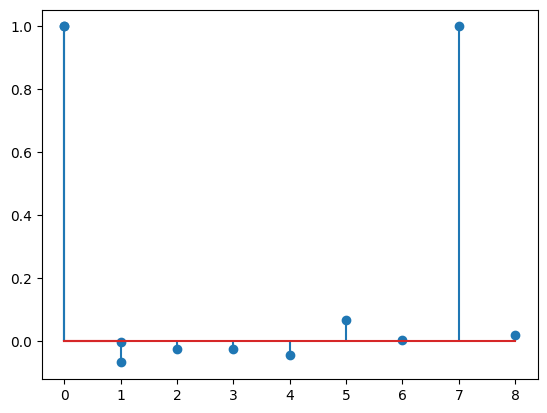

In [17]:
import torchhd, torch
from torchhd import utils

a = torchhd.random(1, 1000, "MAP")
b = torchhd.random(1, 1000, "MAP")

memory = torch.stack([a, b], dim=1).squeeze(dim=0)

print("Pair Similarity:")
# utils.plot_pair_similarity(memory)


print("Pair Similarity:")
utils.plot_similarity(memory[0], memory)

# Permute
p7 = torchhd.permute(a, shifts=7)
permutations = [a,
    torchhd.permute(a, shifts=1),
                torchhd.permute(a, shifts=2),
                torchhd.permute(a, shifts=4),
                torchhd.permute(a, shifts=5),
                torchhd.permute(a, shifts=6),
                p7,
                torchhd.permute(p7, shifts=-7),
                torchhd.permute(a, shifts=9),
                ]

permutations_memory = torch.stack(permutations, dim=1).squeeze(dim=0)

print("Pair Similarity Permutations:")
# utils.plot_pair_similarity(permutations_memory)


print("Pair Similarity Permutations:")
a = permutations_memory[0]
utils.plot_similarity(a, permutations_memory)

dot = torchhd.cos(a, permutations_memory)
print(dot)



# print("--DotProduct---")
# print(f"{torchhd.dot(a, memory)=}")
# print(f"{torchhd.dot(a, b)=}")



In [19]:
a = torch.Tensor([1, 2, 3])
print(a)
print(a.shape)
a_s = a.unsqueeze(0)
print(a_s)
print(a_s.shape)

tensor([1., 2., 3.])
torch.Size([3])
tensor([[1., 2., 3.]])
torch.Size([1, 3])
